mu_c0=  [-0.075  0.2  ]
mu_c1=  [0.3 0.3]
sigma_c0= 
 [[0.25 0.  ]
 [0.   0.3 ]]
sigma_c1= 
 [[0.1 0. ]
 [0.  0.1]]
Boundary 1: y= -3.750000000000001 x+ 0.6718750000000001
Boundary 2: y= -4.2857142857142865 x+ 0.7321428571428572


/home/across/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/across/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in sqrt


Boundary 1: y= -3.750000000000001 x+ 0.6718750000000001
Boundary 2: y= -4.2857142857142865 x+ 0.7321428571428572
Class 0 correct classification percentage
boundary 1:  56.0
boundary 2:  56.4
boundary 3:  100.0
Class 1 correct classification percentage
boundary 1:  52.4
boundary 2:  51.8
boundary 3:  11.0
Boundary 1: y= -3.750000000000001 x+ 0.6718750000000001
Boundary 2: y= -4.2857142857142865 x+ 0.7321428571428572


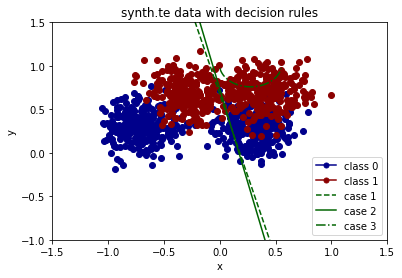

In [167]:
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

pi= 3.14159265359
def calc_mu(data_tr,coordinate):
    n=count_row=data_tr.shape[0]#total number of data points calculation
    return (1/n)*data_tr[coordinate].sum()

def calc_sigma(data_tr,coordinate1,coordinate2):
    n=count_row=data_tr.shape[0]#total number of data points calculation
    a=data_tr[coordinate1]-calc_mu(data_tr,coordinate1)
    b=data_tr[coordinate2]-calc_mu(data_tr,coordinate2)
    #return (1/n)*((data_tr[coordinate1]-calc_mu(data_tr,coordinate1))*(data_tr[coordinate2]-calc_mu(data_tr,coordinate2))).sum()
    return (1/n)*(a*b).sum()

def gaussian_pdf(x,mu,sigma): #calculates p(x|mu,sigma) for x1 and x2
    x=x.reshape(-1,1)
    mu=mu.reshape(-1,1)
    p,_=sigma.shape
    
    sigma_inv=np.linalg.inv(sigma)#determinant of sigma
    a=np.sqrt((2*pi)**p*np.linalg.det(sigma)) #first part of gaussian
    b=-0.5*((x-mu).T @ sigma_inv @ (x-mu)) #second part of gaussian
    return float (1./a)*np.exp(b)

def input_data(filename):
    data = pd.read_csv(filename, sep='\s+', header = 0)
    return data

def boundary_1(x,mu_0,mu_1, sigma_c0, sigma_c1,P_w0,P_w1):
    xcoeff=-(mu_1[0]-mu_0[0])/(mu_1[1]-mu_0[1])
    sigma_c0_b1=([sigma_c0[0,0],0],[0,sigma_c0[1,1]])
    sigma_c1_b1=([sigma_c1[0,0],0],[0,sigma_c1[1,1]])
    sigma=0.5*(np.linalg.det(sigma_c0_b1)+np.linalg.det(sigma_c1_b1))#sigma is the average of 2 determinants
    y_intercept=(1/(mu_1[1]-mu_0[1]))*(sigma*np.log(P_w0/P_w1)+0.5*(np.transpose(mu_1)@mu_1-np.transpose(mu_0)@mu_0))
    print('Boundary 1: y=',xcoeff,'x+',y_intercept)
    return xcoeff*x+y_intercept

def boundary_2(x,mu_0,mu_1, sigma_c0, sigma_c1,P_w0,P_w1):
    sigma=0.5*(sigma_c0+sigma_c1)
    sigma=np.linalg.inv(sigma)
    a=sigma[0,0]*(mu_1[0]-mu_0[0])+sigma[1,0]*(mu_1[1]-mu_0[1])
    b=sigma[0,1]*(mu_1[0]-mu_0[0])+sigma[1,1]*(mu_1[1]-mu_0[1])
    xcoeff=-a/b
    w_x=sigma[0,0]*(mu_0[0]-mu_1[0])+sigma[0,1]*(mu_0[1]-mu_1[1])
    w_y=sigma[1,1]*(mu_0[1]-mu_1[1])+sigma[1,0]*(mu_0[0]-mu_1[0])
    m_minus=mu_0-mu_1
    factor=1/((np.transpose(m_minus))@sigma@m_minus)
    c0=0.5*(mu_0+mu_1)-m_minus*factor*np.log(P_w0/P_w1)
    y_intercept=c0[1]+c0[0]*(w_x/w_y)
    #y_intercept=(w_x/w_y)*c0[0]
    print('Boundary 2: y=',xcoeff,'x+',y_intercept)
    return xcoeff*x+y_intercept

def boundary_3(x,mu_c0,mu_c1, sigma_c0, sigma_c1,P_w0,P_w1):
    sigma_minus=np.linalg.inv(sigma_c1)-np.linalg.inv(sigma_c0)
    k=0.5*np.transpose(mu_c1)@np.linalg.inv(sigma_c1)@mu_c1-0.5*np.transpose(mu_c0)@np.linalg.inv(sigma_c0)@mu_c0+0.5*np.log(np.linalg.det(sigma_c1)/np.linalg.det(sigma_c0))-np.log(P_w1/P_w0)
    mu_sigma_0=np.transpose(mu_c0)@np.linalg.inv(sigma_c0)
    mu_sigma_1=np.transpose(mu_c1)@np.linalg.inv(sigma_c1)
    m=(mu_sigma_1-mu_sigma_0)
    A=m[0]
    B=m[1]
    numerator=-np.sqrt(4*sigma_minus[1][1]*(A*x-sigma_minus[0][0]*x**2+k)+(B-2*sigma_minus[1][0]*x)**2)+B-2*x*sigma_minus[1][0]
    #numerator=-np.sqrt(4*sigma_minus[1][1]*A*x-4*sigma_minus[1][1]*sigma_minus[0][0]*x**2+4*sigma_minus[1][1]*k+B**2-4*B*x+4*x**2)+B-2*x
    return 0.85+numerator/(2*sigma_minus[1][1])
    
def class_check(boundary_type,df,mu_0,mu_1, sigma_c0, sigma_c1,P_w0,P_w1=0.5): # checks which class a point belongs to 
    yline=0
    if boundary_type=='bound_1':
        yline=boundary_1(df['xs'],mu_0,mu_1, sigma_c0, sigma_c1,P_w0,P_w1=0.5)
    if boundary_type=='bound_2':
        yline=boundary_2(df['xs'],mu_0,mu_1, sigma_c0, sigma_c1,P_w0,P_w1=0.5)
    if boundary_type=='bound_3':
        yline=boundary_3(df['xs'],mu_0,mu_1, sigma_c0, sigma_c1,P_w0,P_w1=0.5)

    cond = df['ys'] > yline #if true then belongs to class 1, if false then class 0
    df[boundary_type] = np.where(cond, 1, 0)

data_tr=input_data('synth.tr')
data_tr_c0=data_tr.loc[data_tr.yc==0]# splits data into 2 classes
data_tr_c1=data_tr.loc[data_tr.yc==1]
#data_tr_c1=data_tr_c1.reset_index()
data_tr_c1.drop(columns='yc',axis=1,inplace=True)
#mu1 = [-0.75; 0.2];
#mu2 = [0.3; 0.3];
#S1 = [0.25 0; 0 0.3];
#S2 = [0.1 0; 0 0.1];

mu_c0=np.array([-.075,0.2])#mu calculation
mu_c1=np.array([0.3,0.3])

sigma_c0=np.array([[0.25 ,0],[0, 0.3]])#sigma calculation
sigma_c1=np.array([[0.1,0], [0,0.1]])

x=np.arange(-1.5,1.5,0.01)

print('mu_c0= ',mu_c0)
print('mu_c1= ',mu_c1)
print('sigma_c0= \n',sigma_c0)
print('sigma_c1= \n',sigma_c1)

data_tr=input_data('synth.te')
data_tr_c0=data_tr.loc[data_tr.yc==0]# splits data into 2 classes
data_tr_c1=data_tr.loc[data_tr.yc==1]

P_w0=0.5
P_w1=0.5
class_check('bound_1',data_tr_c0,mu_c0,mu_c1, sigma_c0, sigma_c1,P_w0,P_w1) #counts points above/below boundary
class_check('bound_2',data_tr_c0,mu_c0,mu_c1, sigma_c0, sigma_c1,P_w0,P_w1)
class_check('bound_3',data_tr_c0,mu_c0,mu_c1, sigma_c0, sigma_c1,P_w0,P_w1)
class_check('bound_1',data_tr_c1,mu_c0,mu_c1, sigma_c0, sigma_c1,P_w0,P_w1)
class_check('bound_2',data_tr_c1,mu_c0,mu_c1, sigma_c0, sigma_c1,P_w0,P_w1)
class_check('bound_3',data_tr_c1,mu_c0,mu_c1, sigma_c0, sigma_c1,P_w0,P_w1)

print('Class 0 correct classification percentage')
print('boundary 1: ',100*data_tr_c0.loc[data_tr_c0.bound_1==0].shape[0]/data_tr_c0.shape[0])#calculates % acceptence
print('boundary 2: ',100*data_tr_c0.loc[data_tr_c0.bound_2==0].shape[0]/data_tr_c0.shape[0])
print('boundary 3: ',100*data_tr_c0.loc[data_tr_c0.bound_3==0].shape[0]/data_tr_c0.shape[0])

print('Class 1 correct classification percentage')
print('boundary 1: ',100*data_tr_c1.loc[data_tr_c1.bound_1==1].shape[0]/data_tr_c1.shape[0])#calculates % acceptence
print('boundary 2: ',100*data_tr_c1.loc[data_tr_c1.bound_2==1].shape[0]/data_tr_c1.shape[0])
print('boundary 3: ',100*data_tr_c1.loc[data_tr_c1.bound_3==1].shape[0]/data_tr_c1.shape[0])

plt.plot(x,boundary_1(x,mu_c0,mu_c1, sigma_c0, sigma_c1,P_w0,P_w1),c='DarkGreen',linestyle='--')
plt.plot(x, boundary_2(x,mu_c0,mu_c1, sigma_c0, sigma_c1,P_w0,P_w1),c='DarkGreen',linestyle='-')
plt.plot(x,boundary_3(x,mu_c0,mu_c1, sigma_c0, sigma_c1,P_w0,P_w1),c='DarkGreen',linestyle='-.')
plt.scatter(data_tr_c0['xs'],data_tr_c0['ys'],c='DarkBlue')# plot data
plt.scatter(data_tr_c1['xs'],data_tr_c1['ys'],c='DarkRed')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1.5,1.5)
plt.ylim(-1,1.5)
c_1_leg= mlines.Line2D([], [], color='DarkBlue', marker='o',markersize=5)
c_2_leg= mlines.Line2D([], [], color='DarkRed', marker='o',markersize=5)
b_1_leg= mlines.Line2D([], [], color='DarkGreen', linestyle='--',markersize=5)
b_2_leg= mlines.Line2D([], [], color='DarkGreen',linestyle='-',markersize=5)
b_3_leg= mlines.Line2D([], [], color='DarkGreen',linestyle='-.',markersize=5)
plt.legend((c_1_leg,c_2_leg,b_1_leg,b_2_leg,b_3_leg),('class 0', 'class 1','case 1','case 2', 'case 3'))
plt.title('synth.te data with decision rules')
plt.show()



### 